In [1]:
import FlowCal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap 
import os
import scanpy as sc
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy import sparse
import leidenalg
from constclust import cluster, reconcile, plotting, comp_stats

In [ ]:
# Load file
path = 'sox/B69 DE SOX17 ok.0018.fcs'
file = path.split('/')[1]
exp = file.split(' DE')[0]
og = FlowCal.io.FCSData(path)

# Select channels
channels = ['FSC-A','FSC-H','FSC-W','SSC-A','SSC-W','FL1-A','FL1-W','FL7-A','FL7-W','FL12-A','FL12-W']
# channels = ['FSC-A','FSC-H','FSC-W','SSC-A','SSC-W','FL1-A','FL1-W','FL13-A','FL13-W']
s = og[:,channels]

# Standardize data
s = StandardScaler().fit_transform(s)

# Create anndata object and calculate umap
adata = sc.AnnData(s)
sc.pp.neighbors(adata, random_state=2)
sc.tl.umap(adata, random_state=1)

# load predictions from automatized gating scheme
for f in os.listdir('pred_labels_sox'):
    if f.startswith(exp):
        print(f)
        pred = np.load('pred_labels_sox/'+f)
adata.obs['automatized gating scheme'] = pred
adata.obs['automatized gating scheme'] = adata.obs['automatized gating scheme'].astype('category')

sc.pl.umap(adata, color=['automatized gating scheme'])
sc.pl.umap(adata)

In [5]:
n_neighbors = np.linspace(15, 50, 8, dtype=int)
# resolutions = np.array([0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3])
resolutions = np.array([0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4])
# resolutions = np.array([0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5])

In [ ]:
# Generate clusterings
params, clusterings = cluster(
        adata,
        n_neighbors=n_neighbors,
        resolutions=resolutions,
        random_state=[2],
        n_procs=4
)

# Reconcile clustering solutions into consistent clusters
r = reconcile(params, clusterings)

In [ ]:
# cut off at 90% consensus
comps = r.get_components(.90)
comps.describe().plot.scatter(
        "n_solutions",
        "n_intersect",
)

In [ ]:
# print components with 6 or more solutions
comps.filter(min_solutions=6).plot_components(adata)

In [ ]:
# choose parameter combination
nn = 35
res = 0.35
cond = (params['n_neighbors'] == nn) & (params['resolution'] == res)
idx = np.where(cond)[0][0]
adata.obs[f'leiden (n={nn}, resolution={res})'] = clusterings[idx].astype('category')
sc.pl.umap(adata, color=[f'leiden (n={nn}, resolution={res})', 'automatized gating scheme'], save=f'{exp}_robust_clust_{nn}_{round(res,3)}.png')
# sc.pl.umap(adata, color=[f'leiden (n={nn}, resolution={res})'], save=f'{exp}_robust_clust_{nn}_{round(res,3)}.png')

In [ ]:
# forward scattera against side scatter to identify debris

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=og[:,'FSC-A'], y=og[:,'SSC-A'], hue=clusterings[idx], palette='tab10', s=3, ax=axes[0])
axes[0].set_xlim(-5, 600)
axes[0].set_ylim(-5, 600)
axes[0].set_xlabel('FSC-A')
axes[0].set_ylabel('SSC-A')

# sns.scatterplot(x=og[:,'FSC-A'], y=og[:,'SSC-A'], hue=adata.obs['automatized gating scheme'], palette='tab10', s=3, ax=axes[1])
# axes[1].set_xlim(-5, 400)
# axes[1].set_ylim(-5, 400)
# axes[1].set_xlabel('FSC-A')
# axes[1].set_ylabel('SSC-A')

plt.tight_layout()
plt.show()

In [ ]:
# forward scatter area against forward scatter height to identify doublets

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=og[:,'FSC-A'], y=og[:,'FSC-H'], hue=clusterings[idx], palette='tab10', s=3, ax=axes[0])
axes[0].set_xlim(-5, 700)
axes[0].set_ylim(-5, 500)
axes[0].set_xlabel('FSC-A')
axes[0].set_ylabel('FSC-H')

# sns.scatterplot(x=og[:,'FSC-A'], y=og[:,'FSC-H'], hue=adata.obs['automatized gating scheme'], palette='tab10', s=3, ax=axes[1])
# axes[1].set_xlim(-5, 600)
# axes[1].set_ylim(-5, 400)
# axes[1].set_xlabel('FSC-A')
# axes[1].set_ylabel('FSC-H')

plt.tight_layout()
plt.show()

In [ ]:
# Dead/live against side scatter to identify dead cells

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=og[:,'FL1-A'], y=og[:,'SSC-A'], hue=clusterings[idx], palette='tab10', s=3, ax=axes[0])
# axes[0].set_xlim(-5, 400)
axes[0].set_ylim(-5, 600)
axes[0].set_xscale('log')
axes[0].set_xlabel('FL1-A')
axes[0].set_ylabel('SSC-A')

# sns.scatterplot(x=og[:,'FL1-A'], y=og[:,'SSC-A'], hue=adata.obs['automatized gating scheme'], palette='tab10', s=3, ax=axes[1])
# # axes[1].set_xlim(-5, 400)
# axes[1].set_ylim(-5, 400)
# axes[1].set_xscale('log')
# axes[1].set_xlabel('FL1-A')
# axes[1].set_ylabel('SSC-A')

plt.tight_layout()
plt.show()

In [331]:
# summarize clusters if necessary
labels = clusterings[idx].copy().to_numpy()
# labels[labels == 2] = 1
# labels[labels == 3] = 0
# labels[labels == 6] = 2
# labels[labels == 5] = 0

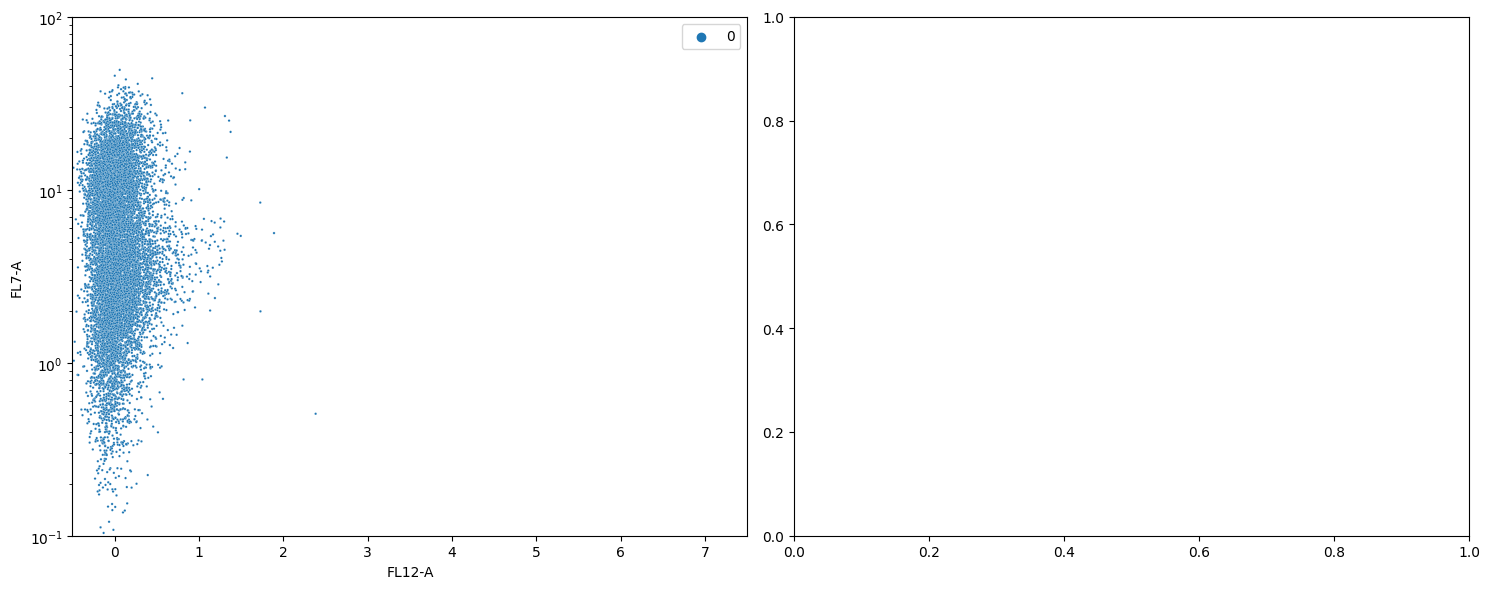

In [332]:
# plot marker intensity

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cond = (labels == 0)
# cond = (labels == 0) | (labels == 1)
# cond = (labels == 0) | (labels == 1) | (labels == 2)
sns.scatterplot(x=og[cond][:,'FL12-A'], y=og[cond][:,'FL7-A'], hue=labels[cond], palette='tab10', s=3, ax=axes[0])
axes[0].set_xlim(-0.5, 7.5)
axes[0].set_ylim(1e-1, 1e2)
axes[0].set_yscale('log')
axes[0].set_xlabel('FL12-A')
axes[0].set_ylabel('FL7-A')

# cond = (pred == 3) | (pred == 4)
# sns.scatterplot(x=og[cond][:,'FL12-A'], y=og[cond][:,'FL7-A'], hue=adata.obs['automatized gating scheme'][cond], palette='tab10', s=3, ax=axes[1])
# axes[1].set_xlim(-0.5, 4.5)
# axes[1].set_ylim(1e0, 1e2)
# axes[1].set_yscale('log')
# axes[1].set_xlabel('FL12-A')
# axes[1].set_ylabel('FL7-A')

plt.tight_layout()
plt.show()

In [726]:
# save labels if summarized
np.save('robust_clust_fox/' + file + '_rc.npy', labels)

In [336]:
# save robust clustering results
np.save('robust_clust_fox/' + file + '_rc.npy', clusterings[idx].to_numpy())

In [337]:
# single cell clusters
clusters = np.array([0])

# create mask for selected clusters
mask = np.isin(clusterings[idx].to_numpy(), clusters)
print('Number of single cells: ', mask.sum())
print('Total number of cells: ', len(mask))

# save mask
np.save('robust_clust_fox/singlets masks/'+exp+'_sc_mask.npy', mask)

Number of single cells:  11623
Total number of cells:  27467
